In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
import pandas as pd

plt.rcParams.update({
    "font.size": 11,
    "axes.labelsize": 12,
    "axes.titlesize": 13,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,

    "axes.spines.top": False,
    "axes.spines.right": False,

    "axes.grid": True,
    "grid.alpha": 0.25,
    "grid.linestyle": "--",

    "errorbar.capsize": 3,
})
%matplotlib inline

In [2]:


with open('../runs/gsmplus_gpu_batch_size_8_max_200/summary.json', 'r') as f:
    summary = json.load(f)

print(summary)


{'dataset': {'name': 'qintongli/GSM-Plus', 'split': 'test'}, 'selected': {'perturbation_types': ['digit expansion', 'distraction insertion', 'integer-decimal-fraction conversion', 'numerical substitution', 'problem understanding'], 'max_per_type': 200, 'n_total': 1000}, 'gen_cfg': {'dtype': 'bfloat16', 'device_map': 'auto', 'max_context_tokens': 8192, 'max_new_tokens_hint': 4096, 'max_new_tokens_sol': 4096, 'do_sample': False, 'temperature': 0.7, 'top_p': 0.9}, 'pipelines': [{'name': 'zeroshot_solver', 'hint_model_id': '', 'solver_model_id': 'Qwen/Qwen3-1.7B'}, {'name': 'rlad_solver_no_hint', 'hint_model_id': '', 'solver_model_id': 'CMU-AIRe/RLAD-Sol-Gen'}, {'name': 'rlad_hint_zeroshot_solver', 'hint_model_id': 'CMU-AIRe/RLAD-Hint-Gen', 'solver_model_id': 'Qwen/Qwen3-1.7B'}, {'name': 'rlad_hint_rlad_solver', 'hint_model_id': 'CMU-AIRe/RLAD-Hint-Gen', 'solver_model_id': 'CMU-AIRe/RLAD-Sol-Gen'}], 'aggregate': {'zeroshot_solver': {'overall': {'n': 1000, 'correct': 800, 'parse_fail': 0, '

In [3]:
# plot a table of the summary, compare each pipeline acc on the different tasks

pipelines = [p['name'] for p in summary['pipelines']]
tasks = list(summary['selected']['perturbation_types'])

results = []

for pipeline in pipelines:
    for task in tasks:
        results.append({'pipeline': pipeline, 
                        'task': task, 
                        'acc': summary['aggregate'][pipeline]['by_perturbation_type'][task]['acc'], 
                        'n': summary['aggregate'][pipeline]['by_perturbation_type'][task]['n'],
                        'ended_with_eos': summary['aggregate'][pipeline]['by_perturbation_type'][task]['ended_with_eos']})

df = pd.DataFrame(results)

print(df)


                     pipeline                                 task    acc  \
0             zeroshot_solver                      digit expansion  0.800   
1             zeroshot_solver                distraction insertion  0.750   
2             zeroshot_solver  integer-decimal-fraction conversion  0.810   
3             zeroshot_solver               numerical substitution  0.785   
4             zeroshot_solver                problem understanding  0.855   
5         rlad_solver_no_hint                      digit expansion  0.810   
6         rlad_solver_no_hint                distraction insertion  0.775   
7         rlad_solver_no_hint  integer-decimal-fraction conversion  0.765   
8         rlad_solver_no_hint               numerical substitution  0.785   
9         rlad_solver_no_hint                problem understanding  0.850   
10  rlad_hint_zeroshot_solver                      digit expansion  0.805   
11  rlad_hint_zeroshot_solver                distraction insertion  0.765   

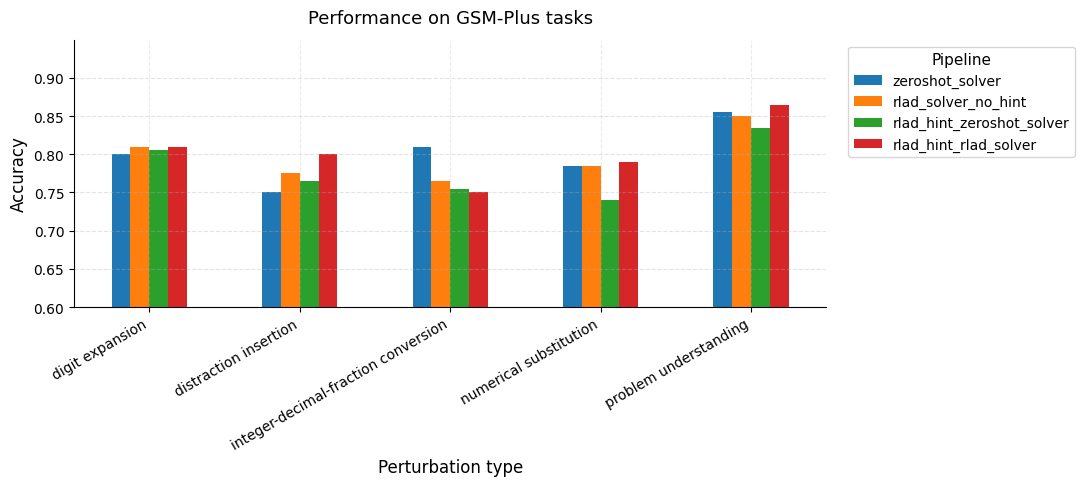

In [4]:
# keep the task/pipeline order from the summary
plot_df = df.copy()
plot_df["task"] = pd.Categorical(plot_df["task"], categories=tasks, ordered=True)
plot_df["pipeline"] = pd.Categorical(plot_df["pipeline"], categories=pipelines, ordered=True)

pivot = plot_df.pivot(index="task", columns="pipeline", values="acc")
ax = pivot.plot(kind="bar", figsize=(11, 5))
ax.set_xlabel("Perturbation type")
ax.set_ylabel("Accuracy")
# use a step size of 0.05

ax.set_yticks(np.arange(0.6, 0.95, 0.05))
ax.set_ylim(0.6, 0.95)
# make the title bold
ax.set_title("Performance on GSM-Plus tasks", pad=12)
ax.yaxis.grid(True, linestyle="--", alpha=0.35)
plt.xticks(rotation=30, ha="right")
plt.legend(title="Pipeline", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.savefig("../figures/gsmplus_tasks.pdf", bbox_inches='tight', dpi=300)
plt.show()


zeroshot_solver digit expansion: 0.95
zeroshot_solver distraction insertion: 0.9
zeroshot_solver integer-decimal-fraction conversion: 0.93
zeroshot_solver numerical substitution: 0.93
zeroshot_solver problem understanding: 0.985
rlad_solver_no_hint digit expansion: 0.925
rlad_solver_no_hint distraction insertion: 0.89
rlad_solver_no_hint integer-decimal-fraction conversion: 0.825
rlad_solver_no_hint numerical substitution: 0.9
rlad_solver_no_hint problem understanding: 0.945
rlad_hint_zeroshot_solver digit expansion: 0.945
rlad_hint_zeroshot_solver distraction insertion: 0.93
rlad_hint_zeroshot_solver integer-decimal-fraction conversion: 0.925
rlad_hint_zeroshot_solver numerical substitution: 0.895
rlad_hint_zeroshot_solver problem understanding: 0.975
rlad_hint_rlad_solver digit expansion: 0.95
rlad_hint_rlad_solver distraction insertion: 0.875
rlad_hint_rlad_solver integer-decimal-fraction conversion: 0.865
rlad_hint_rlad_solver numerical substitution: 0.885
rlad_hint_rlad_solver pro

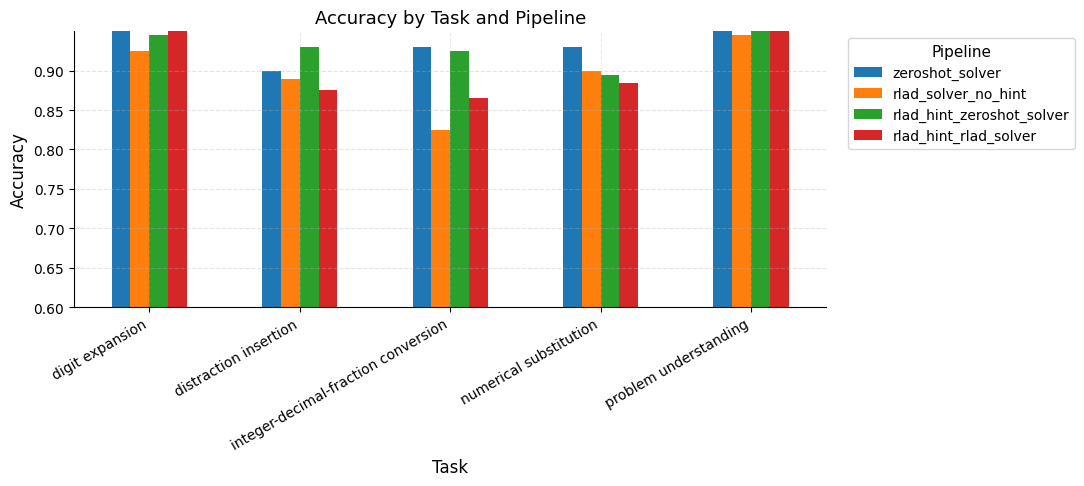

In [5]:
# Measure the number of fractions of answers that ended with eos

for pipeline in pipelines:
    for task in tasks:
        total = summary['aggregate'][pipeline]['by_perturbation_type'][task]['n']
        ended_with_eos = summary['aggregate'][pipeline]['by_perturbation_type'][task]['ended_with_eos']

        print(f"{pipeline} {task}: {ended_with_eos/total}")

# keep the task/pipeline order from the summary
plot_df = df.copy()
plot_df["ended_with_eos"] = plot_df["ended_with_eos"] / plot_df["n"]
plot_df["task"] = pd.Categorical(plot_df["task"], categories=tasks, ordered=True)
plot_df["pipeline"] = pd.Categorical(plot_df["pipeline"], categories=pipelines, ordered=True)

pivot = plot_df.pivot(index="task", columns="pipeline", values="ended_with_eos")
ax = pivot.plot(kind="bar", figsize=(11, 5))
ax.set_xlabel("Task")
ax.set_ylabel("Accuracy")
# use a step size of 0.05
import numpy as np
ax.set_yticks(np.arange(0.6, 0.95, 0.05))
ax.set_ylim(0.6, 0.95)
ax.set_title("Accuracy by Task and Pipeline")
ax.yaxis.grid(True, linestyle="--", alpha=0.35)
plt.xticks(rotation=30, ha="right")
plt.legend(title="Pipeline", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


## Compare context lengths

In [6]:
# Approximate accuracy if solver outputs were truncated to shorter budgets
# Truncate solver_output to N characters and recompute correctness per pipeline/task
import json
import re
from pathlib import Path

records_path = Path("../runs/gsmplus_gpu_batch_size_8_max_200/records.jsonl")
output_dir = records_path.parent
# Character budgets standing in for context/output lengths (edit as needed)
target_char_limits = [2000, 4000, 6000, 8000]

pipelines_ctx = [p["name"] for p in summary["pipelines"]]
tasks_ctx = list(summary["selected"]["perturbation_types"])

num_pattern = re.compile(r"-?\d+(?:\.\d+)?")


def extract_answer(text: str):
    """Extract final numeric answer; prefer boxed if present."""
    boxed = re.findall(r"\boxed{([^}]*)}", text)
    if boxed:
        return boxed[-1].strip()
    nums = num_pattern.findall(text)
    return nums[-1].strip() if nums else None


def evaluate_limit(char_limit: int):
    aggregate = {
    p: {
                "overall": {"n": 0, "correct": 0, "parse_fail": 0, "acc": 0.0},
                "by_perturbation_type": {t: {"n": 0, "correct": 0, "parse_fail": 0, "acc": 0.0} for t in tasks_ctx},
            }
            for p in pipelines_ctx
        }

    with records_path.open() as f:
        for line in f:
            rec = json.loads(line)
            p = rec["pipeline"]
            t = rec["perturbation_type"]
            trimmed = rec["solver_output"][:char_limit]
            pred = extract_answer(trimmed)
            gt = str(rec["ground_truth_answer"]).strip()
            correct = pred is not None and pred == gt

            aggregate[p]["overall"]["n"] += 1
            aggregate[p]["by_perturbation_type"][t]["n"] += 1

            if pred is None:
                aggregate[p]["overall"]["parse_fail"] += 1
                aggregate[p]["by_perturbation_type"][t]["parse_fail"] += 1

            if correct:
                aggregate[p]["overall"]["correct"] += 1
            aggregate[p]["by_perturbation_type"][t]["correct"] += 1

            for p in pipelines_ctx:
                o = aggregate[p]["overall"]
                o["acc"] = o["correct"] / o["n"] if o["n"] else 0.0
                for t in tasks_ctx:
                    bt = aggregate[p]["by_perturbation_type"][t]
                    bt["acc"] = bt["correct"] / bt["n"] if bt["n"] else 0.0

    summary_trimmed = {
        "dataset": summary["dataset"],
        "selected": summary["selected"],
        "gen_cfg": summary["gen_cfg"],
        "pipelines": summary["pipelines"],
        "trim_chars": char_limit,
        "aggregate": aggregate,
    }

    out_path = output_dir / f"summary_contLen_{char_limit}.json"
    with out_path.open("w") as f:
        json.dump(summary_trimmed, f, indent=2)
    return out_path


written_paths = [evaluate_limit(limit) for limit in target_char_limits]
print("Wrote:", written_paths)


Wrote: [PosixPath('../runs/gsmplus_gpu_batch_size_8_max_200/summary_contLen_2000.json'), PosixPath('../runs/gsmplus_gpu_batch_size_8_max_200/summary_contLen_4000.json'), PosixPath('../runs/gsmplus_gpu_batch_size_8_max_200/summary_contLen_6000.json'), PosixPath('../runs/gsmplus_gpu_batch_size_8_max_200/summary_contLen_8000.json')]


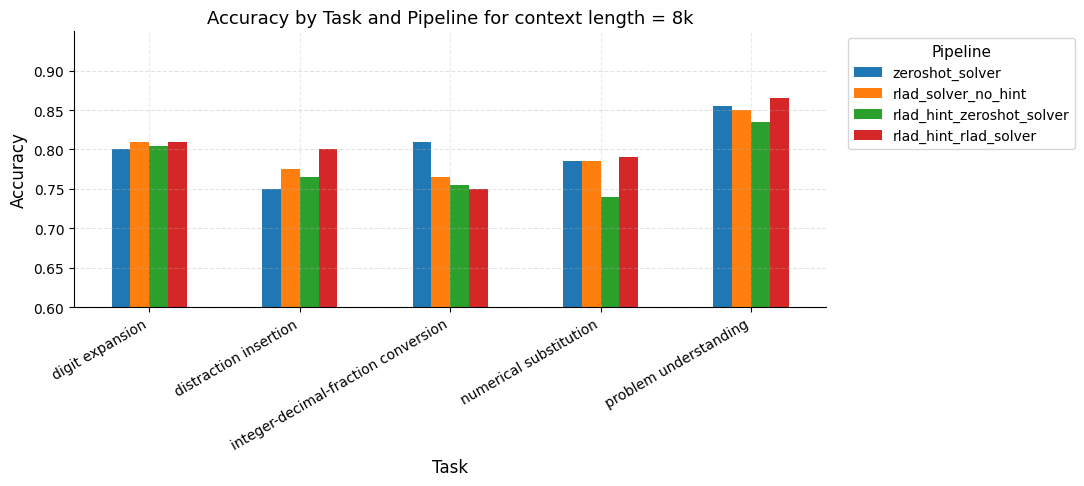

In [7]:
for length in [2000, 4000, 6000, 8000]:
    with open(f"../runs/gsmplus_gpu_batch_size_8_max_200/summary_contLen_{length}.json", "r") as f:
        current_summary = json.load(f)
        

        pipelines = [p['name'] for p in current_summary['pipelines']]
        tasks = list(current_summary['selected']['perturbation_types'])

        results = []

        for pipeline in pipelines:
            for task in tasks:
                results.append({'pipeline': pipeline, 
                                'task': task, 
                                'acc': summary['aggregate'][pipeline]['by_perturbation_type'][task]['acc'], 
                                'n': summary['aggregate'][pipeline]['by_perturbation_type'][task]['n'],
                                'ended_with_eos': summary['aggregate'][pipeline]['by_perturbation_type'][task]['ended_with_eos']})

current_df = pd.DataFrame(results)
plot_df = current_df.copy()
plot_df["task"] = pd.Categorical(plot_df["task"], categories=tasks, ordered=True)
plot_df["pipeline"] = pd.Categorical(plot_df["pipeline"], categories=pipelines, ordered=True)

pivot = plot_df.pivot(index="task", columns="pipeline", values="acc")
ax = pivot.plot(kind="bar", figsize=(11, 5))
ax.set_xlabel("Task")
ax.set_ylabel("Accuracy")

ax.set_yticks(np.arange(0.6, 0.95, 0.05))
ax.set_ylim(0.6, 0.95)
ax.set_title("Accuracy by Task and Pipeline for context length = 8k")
ax.yaxis.grid(True, linestyle="--", alpha=0.35)
plt.xticks(rotation=30, ha="right")
plt.legend(title="Pipeline", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()




In [8]:
results = []
with records_path.open() as f:
        for line in f:
                rec = json.loads(line)
                results.append({
                                "pipeline": rec["pipeline"],
                                "task": rec["perturbation_type"],
                                "solver_output": rec["solver_output"],
                                "correct": rec["correct"],
                        
                        })

In [9]:
out_df = pd.DataFrame(results)

                               task                  pipeline  count     mean  median         std  min   max
                    digit expansion     rlad_hint_rlad_solver    200 4372.425  2777.5 3787.285453  508 16519
                    digit expansion rlad_hint_zeroshot_solver    200 3289.280  1762.0 3618.226317  181 15936
                    digit expansion       rlad_solver_no_hint    200 4277.210  2493.0 3983.019115  299 15873
                    digit expansion           zeroshot_solver    200 3313.190  1787.0 3621.671682  165 16383
              distraction insertion     rlad_hint_rlad_solver    200 5786.595  4035.5 4727.588483  417 17265
              distraction insertion rlad_hint_zeroshot_solver    200 3880.355  2432.0 4004.578943  274 17881
              distraction insertion       rlad_solver_no_hint    200 5703.110  4203.5 4479.146658  246 18078
              distraction insertion           zeroshot_solver    200 4733.220  2641.0 4602.855213  229 17494
integer-decimal-fra

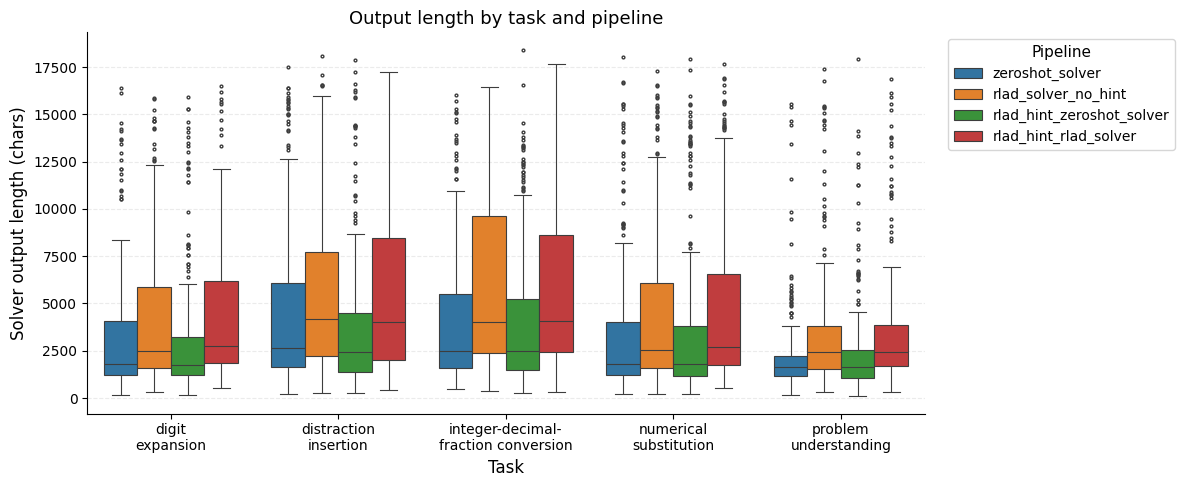

In [10]:
# Measure solver-output lengths per task/pipeline
out_df["len_chars"] = out_df["solver_output"].str.len()

len_stats = (
    out_df.groupby(["task", "pipeline"])["len_chars"]
    .agg(["count", "mean", "median", "std", "min", "max"])
    .reset_index()
)

print(len_stats.sort_values(["task", "pipeline"]).to_string(index=False))


# Shorten task labels for readability
short_labels = {
    "problem understanding": "problem\nunderstanding",
    "numerical substitution": "numerical\nsubstitution",
    "distraction insertion": "distraction\ninsertion",
    "digit expansion": "digit\nexpansion",
    "integer-decimal-fraction conversion": "integer-decimal-\nfraction conversion",
}
out_df["task_short"] = out_df["task"].map(short_labels)

order = [short_labels[t] for t in summary["selected"]["perturbation_types"]]
plt.figure(figsize=(12, 5))
sns.boxplot(
    data=out_df,
    x="task_short",
    y="len_chars",
    hue="pipeline",
    order=order,
    fliersize=2,
    linewidth=0.8,
)
plt.xticks(rotation=0)
plt.ylabel("Solver output length (chars)")
plt.xlabel("Task")
plt.title("Output length by task and pipeline")
plt.legend(title="Pipeline", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


                               task                  pipeline  count     mean  median        std  min  max
                    digit expansion     rlad_hint_rlad_solver    200  836.390   536.0 716.285076   98 3106
                    digit expansion rlad_hint_zeroshot_solver    200  632.685   346.0 696.289344   29 2935
                    digit expansion       rlad_solver_no_hint    200  818.660   485.5 758.672462   57 2961
                    digit expansion           zeroshot_solver    200  633.345   352.0 682.241624   31 3063
              distraction insertion     rlad_hint_rlad_solver    200 1110.990   780.0 902.366075   87 3207
              distraction insertion rlad_hint_zeroshot_solver    200  748.220   470.5 762.687797   53 3205
              distraction insertion       rlad_solver_no_hint    200 1102.045   807.0 856.946785   57 3268
              distraction insertion           zeroshot_solver    200  918.510   510.0 889.105225   53 3472
integer-decimal-fraction conversion  

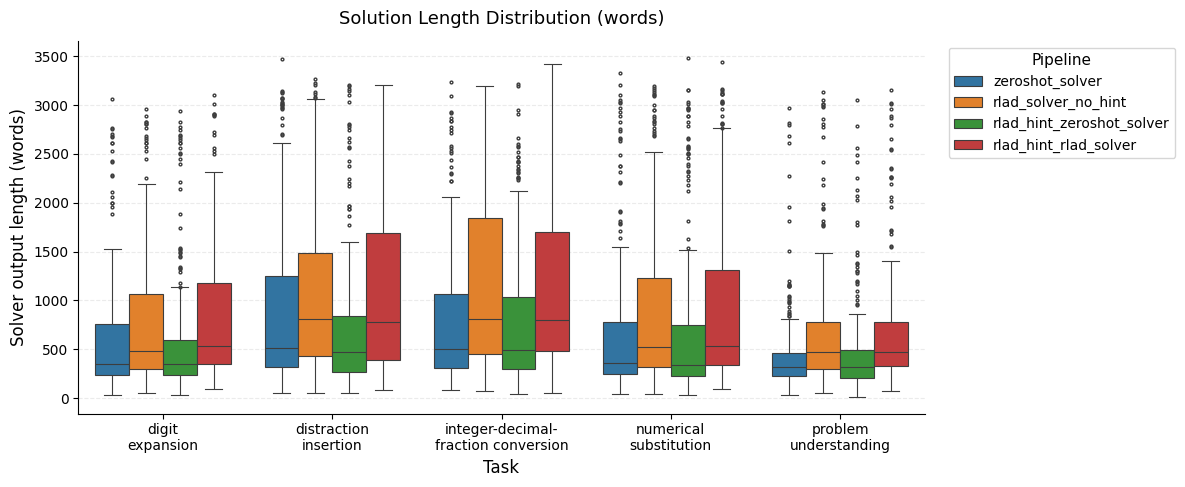

In [11]:
import builtins

# Count words as sequences of non-whitespace characters
out_df["len_words"] = (
    out_df["solver_output"]
    .fillna("")
    .astype(str)
    .str.findall(r"\S+")      # list of "words"
    .map(builtins.len)        # safe even if you overwrote `len`
)

len_stats = (
    out_df.groupby(["task", "pipeline"])["len_words"]
    .agg(["count", "mean", "median", "std", "min", "max"])
    .reset_index()
)

print(len_stats.sort_values(["task", "pipeline"]).to_string(index=False))


short_labels = {
    "problem understanding": "problem\nunderstanding",
    "numerical substitution": "numerical\nsubstitution",
    "distraction insertion": "distraction\ninsertion",
    "digit expansion": "digit\nexpansion",
    "integer-decimal-fraction conversion": "integer-decimal-\nfraction conversion",
}
out_df["task_short"] = out_df["task"].map(short_labels)

order = [short_labels[t] for t in summary["selected"]["perturbation_types"]]
plt.figure(figsize=(12, 5))
sns.boxplot(
    data=out_df,
    x="task_short",
    y="len_words",
    hue="pipeline",
    order=order,
    fliersize=2,
    linewidth=0.8,
)
plt.xticks(rotation=0)
plt.ylabel("Solver output length (words)")
plt.xlabel("Task")
plt.title("Solution Length Distribution (words)",  pad=12)
plt.legend(title="Pipeline", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.savefig("../figures/gsmplus_word_lengths.pdf", bbox_inches='tight', dpi=300)
plt.show()


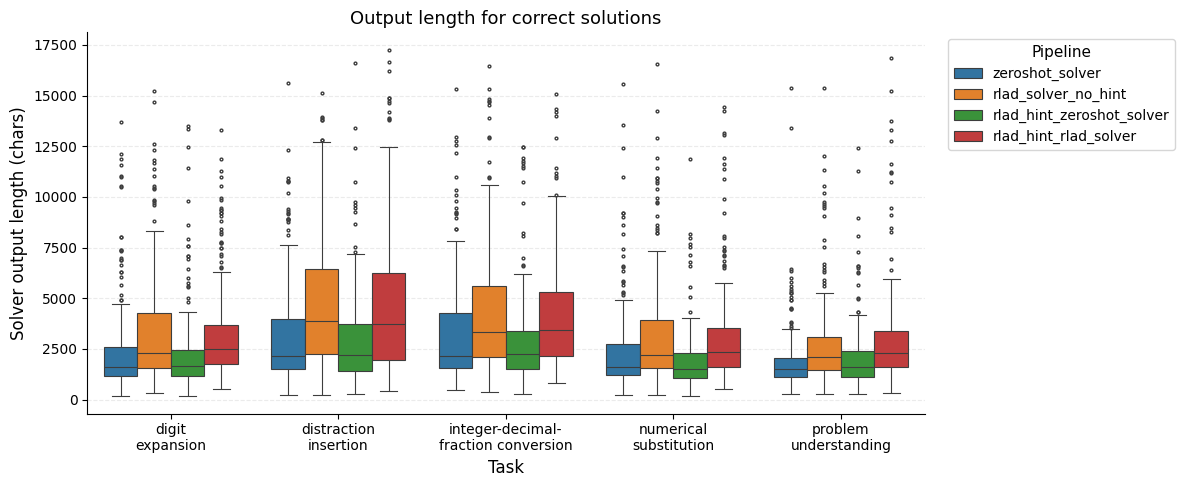

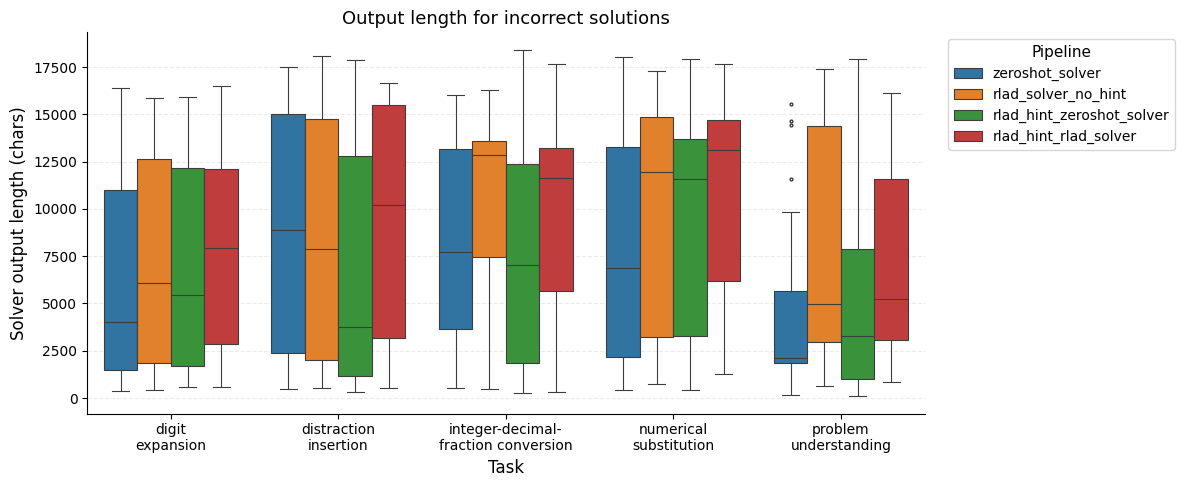

In [12]:
# Output length by correctness split (success vs. failure)

def plot_lengths_by_correct(df_subset, title):
    if df_subset.empty:
        print(f"{title}: no rows to plot")
        return
    plt.figure(figsize=(12, 5))
    sns.boxplot(
        data=df_subset,
        x="task_short",
        y="len_chars",
        hue="pipeline",
        order=order,
        fliersize=2,
    linewidth=0.8,
    )
    plt.xticks(rotation=0)
    plt.ylabel("Solver output length (chars)")
    plt.xlabel("Task")
    plt.title(title)
    plt.legend(title="Pipeline", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

plot_lengths_by_correct(out_df[out_df["correct"]], "Output length for correct solutions")
plot_lengths_by_correct(out_df[~out_df["correct"]], "Output length for incorrect solutions")

In [13]:
import json
from pathlib import Path
import pandas as pd

records_path = Path("../runs/aime25I_max_context_tokens_32768_max_new_tokens_sol_8192_max_new_tokens_hint_1024/records.jsonl")

rows = []
with records_path.open() as f:
    for line in f:
        rec = json.loads(line)
        meta = rec["solutions_meta"]  # shape [n_abs][n_sol] each entry [ended_with_eos, hit_max_new_tokens]

        # flatten all candidates for this example
        flat = [m for abs_row in meta for m in abs_row]
        eos_count = sum(1 for ended, _hit in flat if ended)
        total = len(flat)

        rows.append({
            "pipeline": rec["pipeline"],
            "eos_count": eos_count,
            "total_solutions": total,
            "any_eos": eos_count > 0,
        })

df = pd.DataFrame(rows)

# 1) EOS-ended solutions per pipeline (counts and rate)
eos_by_pipe = (
    df.groupby("pipeline", as_index=False)
      .agg(
          eos_solutions=("eos_count", "sum"),
          total_solutions=("total_solutions", "sum"),
          problems=("pipeline", "size"),
          problems_with_any_eos=("any_eos", "sum"),
      )
)
eos_by_pipe["eos_rate"] = eos_by_pipe["eos_solutions"] / eos_by_pipe["total_solutions"]

print(eos_by_pipe.sort_values("pipeline"))


                    pipeline  eos_solutions  total_solutions  problems  \
0      rlad_hint_rlad_solver             85              240        15   
1  rlad_hint_zeroshot_solver             99              240        15   
2        rlad_solver_no_hint             64              240        15   
3            zeroshot_solver             66              240        15   

   problems_with_any_eos  eos_rate  
0                     12  0.354167  
1                     15  0.412500  
2                      5  0.266667  
3                      8  0.275000  


In [14]:
rows = []
with records_path.open() as f:
    for line in f:
        rec = json.loads(line)
        meta = rec["solutions_meta"]
        
        flat = [m for abs_row in meta for m in abs_row]
        eos_count = sum(1 for ended, _hit in flat if ended)
        hit_max_count = sum(1 for _ended, hit in flat if hit)
        total = len(flat)
        
        # These should account for all solutions
        neither = total - eos_count - hit_max_count
        
        rows.append({
            "pipeline": rec["pipeline"],
            "ended_with_eos": eos_count,
            "hit_max_tokens": hit_max_count,
            "neither": neither,  # Stopped for other reasons
            "total": total,
        })

df = pd.DataFrame(rows)
summary = df.groupby("pipeline").sum()
summary["eos_rate"] = summary["ended_with_eos"] / summary["total"]
summary["hit_max_rate"] = summary["hit_max_tokens"] / summary["total"]
summary["neither_rate"] = summary["neither"] / summary["total"]

print(summary)

                           ended_with_eos  hit_max_tokens  neither  total  \
pipeline                                                                    
rlad_hint_rlad_solver                  85             155        0    240   
rlad_hint_zeroshot_solver              99             141        0    240   
rlad_solver_no_hint                    64             176        0    240   
zeroshot_solver                        66             174        0    240   

                           eos_rate  hit_max_rate  neither_rate  
pipeline                                                         
rlad_hint_rlad_solver      0.354167      0.645833           0.0  
rlad_hint_zeroshot_solver  0.412500      0.587500           0.0  
rlad_solver_no_hint        0.266667      0.733333           0.0  
zeroshot_solver            0.275000      0.725000           0.0  


In [15]:
# -------------------- Defaults --------------------
GSMPLUS_PERTURBATIONS = [
    "problem understanding",
    "numerical substitution",
    "distraction insertion",
    "digit expansion",
    # "critical thinking",
    # "adding operation",
    "integer-decimal-fraction conversion",
    # "reversing operation",
]
from datasets import load_dataset
from typing import List, Dict
# Load dataset
ds = load_dataset("qintongli/GSM-Plus", split="test")

# Choose perturbations
wanted_pts = set(GSMPLUS_PERTURBATIONS)
import random
rnd = random.Random(0)

def group_indices_by_seed_and_perturbation(dataset) -> Dict[str, Dict[str, List[int]]]:
    """
    Returns:
        seed_question -> perturbation_type -> [row indices]
    Notes:
        - We use seed_question as the grouping key when present.
    - If seed_question is missing, we fallback to the example's question text so it's still groupable.
            (You can tighten this if you only want true seed_question rows.)
    """
    groups = defaultdict(lambda: defaultdict(list))
    for i, ex in enumerate(dataset):
        pt = (ex.get("perturbation_type") or "").strip()
        seed_q = (ex.get("seed_question") or "").strip()

        # Fallback so every example can be grouped even if seed_question is empty
        if not seed_q:
            seed_q = (ex.get("question") or ex.get("problem") or "").strip()

        groups[seed_q][pt].append(i)
    return {k: dict(v) for k, v in groups.items()}


from collections import defaultdict
# group by seed_question, then perturbation_type
seed_groups = group_indices_by_seed_and_perturbation(ds)
seeds = list(seed_groups.keys())
# Optionally require each chosen seed to have *all* wanted perturbations
def has_all(seed_q: str) -> bool:
    have = seed_groups[seed_q].keys()
    return all(pt in have and len(seed_groups[seed_q][pt]) > 0 for pt in wanted_pts)

seeds = [s for s in seeds if has_all(s)]

rnd.shuffle(seeds)

# Quick sanity check: peek at one seed + its perturbations without walking all seeds
if seeds:
    sample_seed = seeds[0]
    print(f"Preview seed (after shuffle): {sample_seed}")
    for pt in GSMPLUS_PERTURBATIONS:
        if pt not in wanted_pts:
            continue
        idxs = seed_groups.get(sample_seed, {}).get(pt, [])
        if not idxs:
            continue
        ex = ds[idxs[0]]
        qtext = (ex.get("question") or ex.get("problem") or "").strip()
        print(f"- {pt}: idx {idxs[0]} -> {qtext[:120]}{'...' if len(qtext) > 120 else ''}")

# selected indices = union of (seed -> wanted perturbations)
selected_indices: List[int] = []
per_seed_counts = {}

for seed_q in seeds:
    picked_for_seed = []
    for pt in GSMPLUS_PERTURBATIONS:
        if pt not in wanted_pts:
            continue
        idxs = seed_groups.get(seed_q, {}).get(pt, [])
        if not idxs:
            continue

        picked_for_seed.extend(idxs)

    selected_indices.extend(picked_for_seed)
    per_seed_counts[seed_q] = len(picked_for_seed)

Preview seed (after shuffle): Amber, Micah, and Ahito ran 52 miles in total. Amber ran 8 miles. Micah ran 3.5 times what Amber ran. How many miles did Ahito run?
- problem understanding: idx 8813 -> Together, Amber, Micah, and Ahito covered a distance of 52 miles. Amber managed to run 8 miles. Micah, on the other hand...
- numerical substitution: idx 8808 -> Amber, Micah, and Ahito ran 85 miles in total. Amber ran 15 miles. Micah ran 2.5 times what Amber ran. How many miles di...
- distraction insertion: idx 8814 -> Amber, Micah, and Ahito ran 52 miles in total. Mike ran 6 miles. Amber ran 8 miles. Micah ran 3.5 times what Amber ran. ...
- digit expansion: idx 8809 -> Amber, Micah, and Ahito ran 5200 miles in total. Amber ran 800 miles. Micah ran 3.5 times what Amber ran. How many miles...
- integer-decimal-fraction conversion: idx 8810 -> Amber, Micah, and Ahito ran 52.5 miles in total. Amber ran 8.2 miles. Micah ran 3.5 times what Amber ran. How many miles...
